## **Mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Import **libraries**

In [2]:
# Based from the tutorial of Jason Brownlee on Recurrent Neural Networks
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import pandas as pd
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import LSTM,BatchNormalization,Activation,RepeatVector,TimeDistributed
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
plt.style.use('ggplot')


Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
#np.random.seed(10)

## **Read Dataset**

In [3]:
#Use the flood_data.csv dataset
file = '/content/drive/My Drive/Colab Notebooks/usgs_buffalo_bayou_06_17_2019.csv'#usgs_sm_lost_creek_final1.csv
df = pd.read_csv(file, engine='python')


columnTitles=['Date','Discharge(cft/sec)','precipitation(feet)','gage height(feet)'] #'SoilMoisture'


df = df.reindex(columns=columnTitles)

df = df.set_index('Date')
dataset   = df.values
dataset   = dataset.astype('float64')
print(dataset)
df.head()

#print(np.max(dataset[:,3]))

[[1010.      0.     41.37]
 [1000.      0.     41.35]
 [1000.      0.     41.33]
 ...
 [ 444.      0.     38.52]
 [ 435.      0.     38.47]
 [ 422.      0.     38.39]]


,Discharge(cft/sec),precipitation(feet),gage height(feet)
Date,,,
2019-01-26 00:00:00,1010.0,0.0,41.37
2019-01-26 00:15:00,1000.0,0.0,41.35
2019-01-26 00:30:00,1000.0,0.0,41.33
2019-01-26 00:45:00,988.0,0.0,41.28
2019-01-26 01:00:00,982.0,0.0,41.25


## **Instantiate Standard Scaler - Normalisation**

In [0]:

scaler  = StandardScaler()


## **Create samples using sliding window approach**

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    #print(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    #print(agg)
    return agg

## **Preparing training dataset for Encoder Decoder model**

In [0]:
df_new = series_to_supervised(dataset,4,10)

supervised_values_new = df_new.values

supervised_values_new_copy = supervised_values_new.copy()

np.random.shuffle(supervised_values_new)


train_len1 = int(len(supervised_values_new)*0.67)



train1 = supervised_values_new[:train_len1,:]
test1 =  supervised_values_new[train_len1:,:]

scaler1  = StandardScaler()

#val = scaler.fit_transform(dataset)


train1 = scaler1.fit_transform(train1)



test1 = scaler1.transform(test1)
    
trainX_new = train1[:,0:4*3]
trainY_new = train1[:,[12,14,15,17,18,20,21,23]]

testX_new = test1[:,0:4*3]
testY_new = test1[:,[12,14,15,17,18,20,21,23]]



In [0]:
trainX_shaped_new = trainX_new.reshape(len(trainX_new),4,3)
trainY_shaped_new = trainY_new.reshape(len(trainY_new),4,2)
testX_shaped_new = testX_new.reshape(len(testX_new),4,3)
testY_shaped_new = testY_new.reshape(len(testY_new),4,2)

print(scaler1.inverse_transform(test1)[:,-1])

[38.88 46.7  35.92 ... 36.31 36.23 35.97]


# **Encoder Decoder model for Multi-step ahead forecasting**

In [0]:
model1 = Sequential()
model1.add(LSTM(200, activation='relu', input_shape=(4, 3)))
model1.add(RepeatVector(4))
model1.add(LSTM(200, activation='relu', return_sequences=True))
model1.add(TimeDistributed(Dense(2)))
model1.compile(optimizer='adam', loss='mae')

history1 = model1.fit(trainX_shaped_new, trainY_shaped_new, batch_size = 100,epochs=100, verbose=2,validation_data=(testX_shaped_new,testY_shaped_new))



W0615 22:05:24.190511 139708618372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 22:05:24.211898 139708618372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 22:05:24.214643 139708618372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 22:05:24.662798 139708618372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0615 22:05:24.875127 139708618372992 deprecation.py:323

Train on 7758 samples, validate on 3822 samples
Epoch 1/100
 - 3s - loss: 0.1941 - val_loss: 0.0406
Epoch 2/100
 - 1s - loss: 0.0316 - val_loss: 0.0267
Epoch 3/100
 - 1s - loss: 0.0304 - val_loss: 0.0289
Epoch 4/100
 - 1s - loss: 0.0260 - val_loss: 0.0240
Epoch 5/100
 - 1s - loss: 0.0240 - val_loss: 0.0293
Epoch 6/100
 - 1s - loss: 0.0232 - val_loss: 0.0263
Epoch 7/100
 - 1s - loss: 0.0247 - val_loss: 0.0237
Epoch 8/100
 - 1s - loss: 0.0210 - val_loss: 0.0321
Epoch 9/100
 - 1s - loss: 0.0219 - val_loss: 0.0214
Epoch 10/100
 - 1s - loss: 0.0216 - val_loss: 0.0216
Epoch 11/100
 - 1s - loss: 0.0217 - val_loss: 0.0207
Epoch 12/100
 - 1s - loss: 0.0196 - val_loss: 0.0234
Epoch 13/100
 - 1s - loss: 0.0197 - val_loss: 0.0188
Epoch 14/100
 - 1s - loss: 0.0202 - val_loss: 0.0230
Epoch 15/100
 - 1s - loss: 0.0179 - val_loss: 0.0184
Epoch 16/100
 - 1s - loss: 0.0217 - val_loss: 0.0405
Epoch 17/100
 - 1s - loss: 0.0192 - val_loss: 0.0183
Epoch 18/100
 - 1s - loss: 0.0173 - val_loss: 0.0219
Epoch 1

In [0]:
from keras.utils.vis_utils import plot_model

plot_model(model1, to_file='/content/drive/My Drive/Colab Notebooks/enc.png', show_shapes=True, show_layer_names=True)

## **Plot training loss**

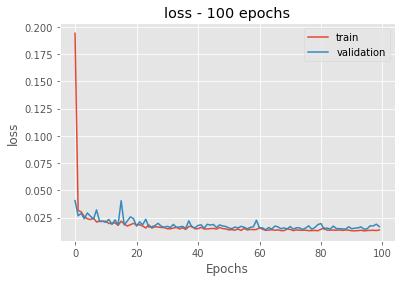

In [0]:
plt.plot(history1.history['loss'],label="train")
plt.plot(history1.history['val_loss'],label="validation")
plt.legend(loc="upper right")
plt.title("loss - 100 epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

## **Encoder Decoder model**

In [0]:
print(model1.summary())

#model1.save_weights("/content/drive/My Drive/Colab Notebooks/encDec_8.h5")


model_json = model1.to_json()
with open("/content/drive/My Drive/Colab Notebooks/encDec_8_other.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("/content/drive/My Drive/Colab Notebooks/encDec_8_other.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               163200    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 200)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 200)            320800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 3)              603       
Total params: 484,603
Trainable params: 484,603
Non-trainable params: 0
_________________________________________________________________
None
Saved model to disk


## **Model metrics for training and test data**

In [0]:
testScore = model1.evaluate(testX_shaped_new, testY_shaped_new, verbose=0)
#print(testScore)
print('Test Score: %.2f RMSE' % (math.sqrt(testScore)))

trainScore = model1.evaluate(trainX_shaped_new, trainY_shaped_new, verbose=0)
#print(trainScore)

print('Train Score: %.2f RMSE' % (math.sqrt(trainScore)))

Test Score: 0.44 RMSE
Train Score: 0.41 RMSE


## **Plot 10 Time step ahead predictions of Encoder Decoder Model**

0.07756824100412407
0.09628767293588218
0.13070964309752572
0.19818908776896804
MAE
0.03244520480448497
0.04310506012674274
0.05333563662782062
0.06849910889390462


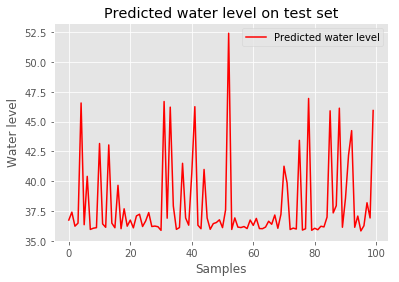

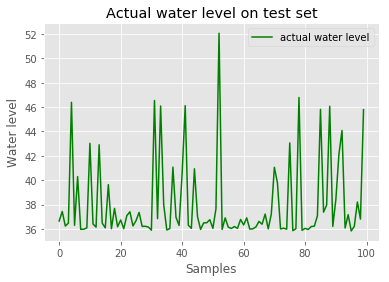

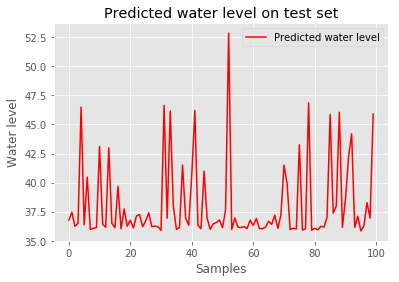

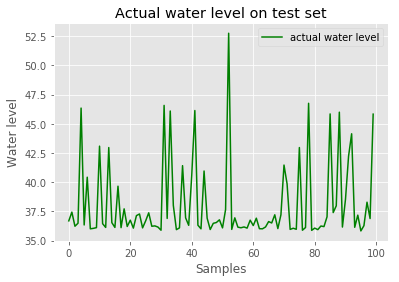

In [0]:
pred_y = model1.predict(testX_shaped_new)


testX_reshape = testX_shaped_new.reshape(len(testX_shaped_new),12)

pred_y_reshape = pred_y.reshape(len(pred_y),8)

temp = np.concatenate((testX_reshape,np.asarray(pred_y_reshape[:,0]).reshape(len(pred_y_reshape),-1),np.asarray(test1[:,13]).reshape(len(test1),-1)),axis=1)
temp = np.concatenate((temp,np.asarray(pred_y_reshape[:,1]).reshape(len(pred_y_reshape),-1)),axis=1)

temp = np.concatenate((temp,np.asarray(pred_y_reshape[:,2]).reshape(len(pred_y_reshape),-1),np.asarray(test1[:,16]).reshape(len(test1),-1)),axis=1)
temp = np.concatenate((temp,np.asarray(pred_y_reshape[:,3]).reshape(len(pred_y_reshape),-1)),axis=1)

temp = np.concatenate((temp,np.asarray(pred_y_reshape[:,4]).reshape(len(pred_y_reshape),-1),np.asarray(test1[:,19]).reshape(len(test1),-1)),axis=1)
temp = np.concatenate((temp,np.asarray(pred_y_reshape[:,5]).reshape(len(pred_y_reshape),-1)),axis=1)

temp = np.concatenate((temp,np.asarray(pred_y_reshape[:,6]).reshape(len(pred_y_reshape),-1),np.asarray(test1[:,22]).reshape(len(test1),-1)),axis=1)
temp = np.concatenate((temp,np.asarray(pred_y_reshape[:,7]).reshape(len(pred_y_reshape),-1)),axis=1)

preds_inv = scaler1.inverse_transform(temp)


test1_inv = scaler1.inverse_transform(test1)

print(math.sqrt(mean_squared_error(test1_inv[:,14],preds_inv[:,14])))

print(math.sqrt(mean_squared_error(test1_inv[:,17],preds_inv[:,17])))

print(math.sqrt(mean_squared_error(test1_inv[:,20],preds_inv[:,20])))

print(math.sqrt(mean_squared_error(test1_inv[:,23],preds_inv[:,23])))

print("MAE")

print(mean_absolute_error(test1_inv[:,14],preds_inv[:,14]))

print(mean_absolute_error(test1_inv[:,17],preds_inv[:,17]))

print(mean_absolute_error(test1_inv[:,20],preds_inv[:,20]))

print(mean_absolute_error(test1_inv[:,23],preds_inv[:,23]))

len1 = np.random.randint(0,len(test1))

#plt.plot(preds_inv[len1:len1+100,20],label="Predicted water level",color="red")
# plt.legend(loc= "upper right")
# plt.title("Predicted water level on test set")
# plt.xlabel("Samples")
# plt.ylabel("Water level")
# plt.show()
# plt.plot(test1_inv[len1:len1+100,20],label="actual water level",color="green")
# plt.legend(loc= "upper right")
# plt.title("Actual water level on test set")
# plt.xlabel("Samples")
# plt.ylabel("Water level")
# plt.show()

plt.plot(preds_inv[len1:len1+100,23],label="Predicted water level",color="red")
plt.legend(loc= "upper right")
plt.title("Predicted water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()
plt.plot(test1_inv[len1:len1+100,23],label="actual water level",color="green")
plt.legend(loc= "upper right")
plt.title("Actual water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()

# plt.plot(preds_inv[len1:len1+100,17],label="Predicted water level",color="red")
# plt.legend(loc= "upper right")
# plt.title("Predicted water level on test set")
# plt.xlabel("Samples")
# plt.ylabel("Water level")
# plt.show()
# plt.plot(test1_inv[len1:len1+100,17],label="actual water level",color="green")
# plt.legend(loc= "upper right")
# plt.title("Actual water level on test set")
# plt.xlabel("Samples")
# plt.ylabel("Water level")
# plt.show()

plt.plot(preds_inv[len1:len1+100,14],label="Predicted water level",color="red")
plt.legend(loc= "upper right")
plt.title("Predicted water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()
plt.plot(test1_inv[len1:len1+100,14],label="actual water level",color="green")
plt.legend(loc= "upper right")
plt.title("Actual water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()




In [0]:
from keras.utils.vis_utils import plot_model

plot_model(model1, to_file='/content/drive/My Drive/Colab Notebooks/enc.png', show_shapes=True, show_layer_names=True)

In [0]:
len1 = np.random.randint(0,len(test1))



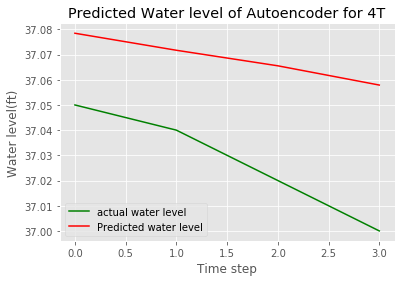

In [0]:
plt.plot(test1_inv[len1,[14,17,20,23]],label="actual water level",color="green")
plt.plot(preds_inv[len1,[14,17,20,23]],label="Predicted water level",color="red")
plt.title("Predicted Water level of Autoencoder for 4T")
plt.xlabel("Time step")
plt.ylabel("Water level(ft)")
plt.legend(loc="lower left")
plt.show()

[40.96923023 37.96311081 36.86997648 ... 36.0298825  41.00971669
 37.05216553]
[41.05578932 37.90234933 36.80688336 ... 36.04660307 41.15683078
 37.03099768]
[40.94291483 37.94362819 36.82902842 ... 35.99814496 41.02397663
 37.07221382]
[41.02861859 37.94403995 36.81966352 ... 36.00161031 41.13673325
 37.03049782]
r-2 score : 0.01
r-2 score : 0.02
r-2 score : 0.01
r-2 score : 0.02


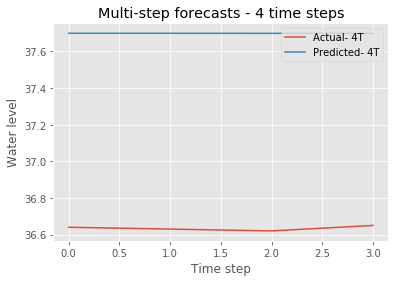

In [0]:
train_X_new = trainX_shaped_new.reshape((trainX_shaped_new.shape[0], 12))

train_predict = model1.predict(trainX_shaped_new)

# invert scaling for forecast
inv_yhat_train_new = np.concatenate((train_X_new,train_predict.reshape((train_predict.shape[0], 12))), axis=1)
#.reshape(len(testPredict),12

#print(inv_yhat)
train_inv_new = scaler.inverse_transform(train1)

inv_yhat_train_new = scaler.inverse_transform(inv_yhat_train_new)

print(train_inv_new[:,14])
print(inv_yhat_train_new[:,14])

print(train_inv_new[:,20])
print(inv_yhat_train_new[:,20])



print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,14],inv_yhat_train_new[:,14])))

print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,17],inv_yhat_train_new[:,17])))
print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,20],inv_yhat_train_new[:,20])))
print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,23],inv_yhat_train_new[:,23])))
len1 = np.random.randint(0,len(test))
plt.plot(test[len1,[14,17,20,23]],label="Actual- 4T")
plt.plot(inv_yhat[len1,[14,17,20,23]],label="Predicted- 4T")
plt.title("Multi-step forecasts - 4 time steps")
plt.xlabel("Time step")
plt.ylabel("Water level")
plt.legend(loc="upper right")
plt.show()
# print(mean_squared_error(train[:,-1],inv_yhat_train[:,-1]))

In [0]:
print('Test Score for time step t: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,19],preds_inv[:,19]))))

print('Test Score for time step t + 1: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,23],preds_inv[:,23]))))



print('Test Score for time step t + 2: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,27],preds_inv[:,27]))))

print('Test Score for time step t + 3: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,31],preds_inv[:,31]))))



print('Test Score for time step t + 4: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,35],preds_inv[:,35]))))

print('Test Score for time step t + 5: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,39],preds_inv[:,39]))))


print('Test Score for time step t + 6: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,43],preds_inv[:,43]))))

print('Test Score for time step t + 7: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,47],preds_inv[:,47]))))


print('Test Score for time step t + 8: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,51],preds_inv[:,51]))))

print('Test Score for time step t + 9: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,55],preds_inv[:,51]))))

Test Score for time step t: 0.008044 RMSE
Test Score for time step t + 1: 0.008211 RMSE
Test Score for time step t + 2: 0.008933 RMSE
Test Score for time step t + 3: 0.009983 RMSE
Test Score for time step t + 4: 0.011586 RMSE
Test Score for time step t + 5: 0.010954 RMSE
Test Score for time step t + 6: 0.010738 RMSE
Test Score for time step t + 7: 0.010775 RMSE
Test Score for time step t + 8: 0.011097 RMSE
Test Score for time step t + 9: 0.011451 RMSE


## ***Comparison of models - 10 time step ahead predictions using  Encoder Decoder model  and one step ahead forecasting model ***

In [0]:

# predictions = moving_test_window_preds(10)

# fig = plt.figure(facecolor='white')
# ax = fig.add_subplot(111)
# ax.plot(testY_transformed, label='True Data')
# # Pad the list of predictions to shift it in the graph to it's correct start
# for i, data in enumerate(predictions):
#   padding = []
#   for j in range((i+1) * 10):
#     padding.append(None)
#   for k in range(len(data[:,3])):
#     padding.append(data[k,3]) 
#   #print(padding)
#   plt.plot(padding , label='Prediction')
#   plt.legend()
#   plt.show()